In [11]:
from tsai.all import *
import pandas as pd
from datenverarbeitung.dataloader import dataloader
from IPython.display import clear_output
import datetime
CUDA_LAUNCH_BLOCKING=1

num_scenario = 1
model_to_use = "InceptionTimePlus"
learning_cycles = 1
features_to_learn_with = ["nosetip_y"]
plots_folder = "vis/plots"
save_name = "scenario_{}_{}".format(num_scenario, model_to_use)

dl = dataloader(scenario= num_scenario, path="/Users/adi/Nextcloud/smart_hans/AP2/Daten/headpose_opencv_pitch_roll_yaw_20220904", nr_taps=1, move_window_by=-10, feature_list=features_to_learn_with)
train, test= dl.get_train_test(frac = 0.8, seed = 0)

X_test, y_test = df2xy(test, target_col='target')
X_train, y_train = df2xy(train, target_col='target')

X, y, splits = combine_split_data([X_train, X_test], [y_train, y_test])

tfms  = [None, [Categorize()]]
dsets = TSDatasets(X, y, tfms=tfms, splits=splits, inplace=True)
dsets

dls = TSDataLoaders.from_dsets(dsets.train, dsets.valid, bs=[64, 128], batch_tfms=[TSStandardize()], num_workers=0)




smart_hans_08022022_194751_7_250-281_08_gny_.csv
smart_hans_08022022_192131_8_280-310_08_wny_.csv
smart_hans_08022022_190823_13_429-460_08_mny_person_hat_nicht_auf_huf_geschaut.csv
smart_hans_07312022_170216_4_149-178_08_mgy_furz_lachen_am_ende.csv
smart_hans_08022022_182746_7_242-273_08_wny_.csv
smart_hans_08022022_184110_5_176-207_08_mgy_.csv
smart_hans_07312022_185231_4_153-182_08_mny_.csv
smart_hans_07312022_174011_10_330-358_08_mny_.csv
smart_hans_08022022_192219_4_154-184_08_wny_person_hat_nach_12_gewackelt.csv
smart_hans_08022022_191248_9_307-336_08_mny_.csv
smart_hans_08022022_205208_8_276-308_08_wnn_.csv
smart_hans_08022022_191134_12_403-433_08_mny_.csv
smart_hans_08022022_185137_12_400-430_08_mny_.csv
smart_hans_08022022_172713_13_435-465_08_mgn_.csv
smart_hans_08022022_211022_9_314-345_08_mgy_.csv
smart_hans_07312022_164838_8_276-305_08_mgy_klatschen_8_ende.csv
smart_hans_08022022_184808_8_276-305_08_mny_.csv
smart_hans_08022022_195222_3_123-154_08_gny_.csv
smart_hans_080220

FCN


epoch,train_loss,valid_loss,accuracy,time
0,0.960543,0.908988,0.563441,00:02


,arch,hyperparams,train loss,valid loss,accuracy,time
0,FCN,{},0.960543,0.908988,0.563441,2


ResNet


epoch,train_loss,valid_loss,accuracy,time


KeyboardInterrupt: 

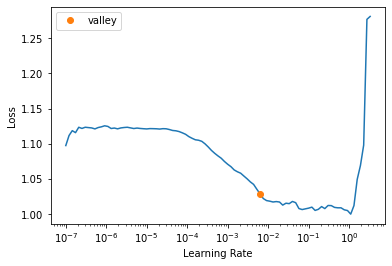

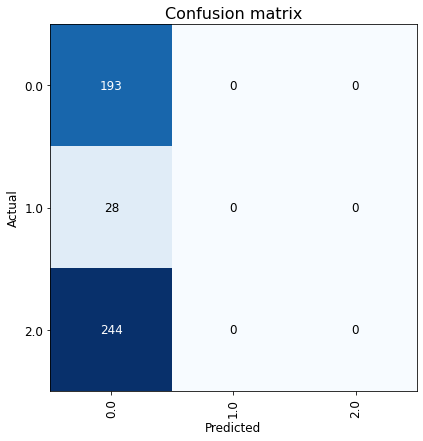

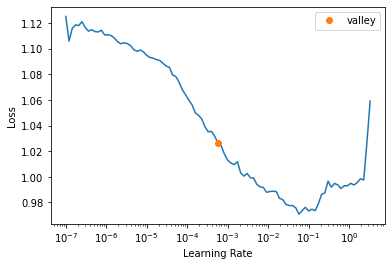

In [12]:
archs = [(FCN, {}), (ResNet, {}), (xresnet1d34, {}), (ResCNN, {}), 
        (LSTM, {'n_layers':1, 'bidirectional': False}), (LSTM, {'n_layers':2, 'bidirectional': False}), (LSTM, {'n_layers':3, 'bidirectional': False}), 
        (LSTM, {'n_layers':1, 'bidirectional': True}), (LSTM, {'n_layers':2, 'bidirectional': True}), (LSTM, {'n_layers':3, 'bidirectional': True}),
        (LSTM_FCN, {}), (LSTM_FCN, {'shuffle': False}), (InceptionTime, {}), (XceptionTime, {}), (OmniScaleCNN, {}), (mWDN, {'levels': 4})]

results = pd.DataFrame(columns=['arch', 'hyperparams',  'train loss', 'valid loss', 'accuracy', 'time'])
for i, (arch, k) in enumerate(archs):

    save_name = "scenario_{}_{}".format(num_scenario, arch.__name__)
    ## set parameters for modelsaves
    scenario_name_stage0 = save_name+"_stage0"

    model = create_model(arch, dls=dls, **k)
    print(model.__class__.__name__)
    learn = Learner(dls, model,  metrics=accuracy)

    learn.save(scenario_name_stage0)
    learn.load(scenario_name_stage0)
    learn.lr_find()
    scenario_name_stage1 = scenario_name_stage0.replace("0","1")

    start = time.time()
    learn.fit_one_cycle(learning_cycles, 1e-3)
    elapsed = time.time() - start
    vals = learn.recorder.values[-1]
    results.loc[i] = [arch.__name__, k, vals[0], vals[1], vals[2], int(elapsed)]
    results.sort_values(by='accuracy', ascending=False, ignore_index=True, inplace=True)

    learn.plot_confusion_matrix()
    feature_list_string = '_'.join(features_to_learn_with)
    current_time= datetime.datetime.now().strftime('%d%m%Y_%H%M%S')
    plot_name = plots_folder+"/confusion_matrix_"+save_name+"_features_{}_learning_cycles_{}_{}.png".format(feature_list_string,learning_cycles, current_time)
    plt.savefig(plot_name, ext='png', bbox_inches="tight")
    clear_output(wait=True)
    display(results)